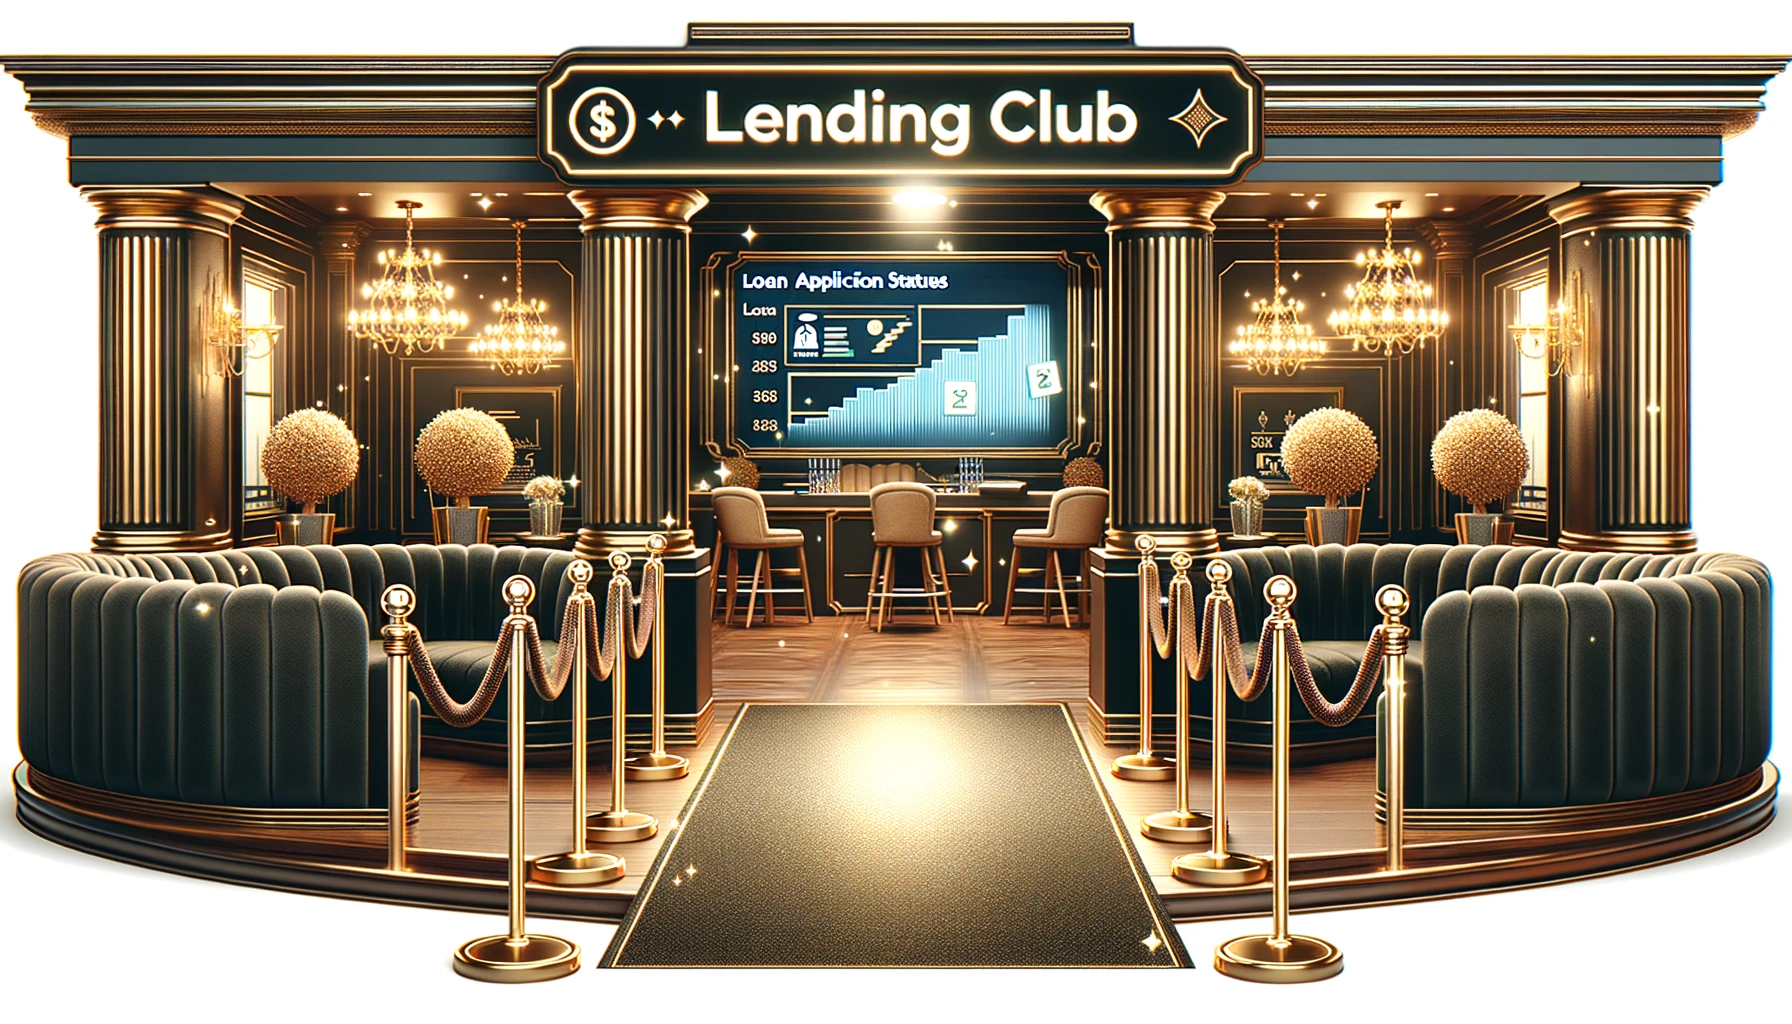

# Introduction

I am a data scientist who was just hired by the LendingClub. They want to automate their lending decisions fully, and they hired me to lead this project. My team consists of a product manager to help me understand the business domain and a software engineer who will help me integrate my solution into their product. During the initial investigations, I've found that there was a similar initiative in the past, and luckily for me, they have left a somewhat clean dataset of LendingClub's loan data.

In the first meeting with my team, we all have decided to use this dataset because it will allow me to skip months of work of building a dataset from scratch. In addition, I have decided to tackle this problem iteratively so that I can get test my hypothesis that I can automate these decisions and get actual feedback from the users as soon as possible. For that, I have proposed a few-step plan on how to approach this problem:

- The first step of my plan is to create a machine learning model to classify loans into accepted/rejected so that I can start learning if I have enough data to solve this simple problem adequately.

- The second step is to predict the grade for the loan.

- The third step is to predict the subgrade and/or interest rate.

My team likes the plan, especially because after every step, I'll have a fully-working deployed model that my company can use. Excitedly I get to work!

# Data load and overview

In [1]:
import pandas as pd
import numpy as np

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import os

from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

import random

import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Download NLTK stop words if not already present (uncomment)
# nltk.download("stopwords")
# nltk.download("punkt")

# Beautify the code with nb_black package to adhere to PEP8 requirements
%load_ext nb_black

# Increase the sharpness of graphical elements
%config InlineBackend.figure_format = 'svg'

<IPython.core.display.Javascript object>

In [2]:
df_accept = pd.read_csv(
    "/Users/drkazimieras/Turing College/Lending club/accepted_2007_to_2018Q4.csv",
    low_memory=False,
)

<IPython.core.display.Javascript object>

In [3]:
df_reject = pd.read_csv(
    "/Users/drkazimieras/Turing College/Lending club/rejected_2007_to_2018Q4.csv"
)

<IPython.core.display.Javascript object>

In [4]:
pd.set_option("display.max_columns", None)
df_accept.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Dec-2015   
1  10+ years       MORTGAGE     65000.0        Not Verified  Dec-2015   
2  10+ years       MORTGAGE     63000.0        Not Verified  Dec-2015   
3  10+ years       MORTGAGE    110000.0     Source Verified  Dec-2015   
4    3 years       MORTGAGE    104433.0     Source Verified  Dec-2015   

  loan_status pymnt_plan                                                url  \
0  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
1  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
2  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
3     Current          n  https://lendingclub.com/browse/loanDetail.acti...   
4  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   

  desc             purpose               title zip_code addr_state    dti  \
0  NaN  debt_consolidation  Debt consolidation    190xx         PA   5.91   
1  NaN      small_business            Business    577xx         SD  16.06   
2  NaN    home_improvement                 NaN    605xx         IL  10.78   
3  NaN  debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4  NaN      major_purchase      Major purchase    174xx         PA  25.37   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-2003           675.0            679.0   
1          1.0         Dec-1999           715.0            719.0   
2          0.0         Aug-2000           695.0            699.0   
3          0.0         Sep-2008           785.0            789.0   
4          1.0         Jun-1998           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                    30.0                     NaN       7.0   
1             4.0                     6.0                     NaN      22.0   
2             0.0                     NaN                     NaN       6.0   
3             0.0                     NaN                     NaN      13.0   
4             3.0                    12.0                     NaN      12.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0     2765.0        29.7       13.0                   w       0.00   
1      0.0    21470.0        19.2       38.0                   w       0.00   
2      0.0     7869.0        56.2       18.0                   w       0.00   
3      0.0     7802.0        11.6       17.0                   w   15897.65   
4      0.0    21929.0        64.5       35.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00   4421.723917          4421.72          3600.00   
1           0.00  25679.660000         25679.66         24700.00   
2           0.00  22705.924294         22705.92         20000.00   
3       15897.65  31464.010000         31464.01         19102.35   
4           0.00  1

<IPython.core.display.Javascript object>

In [5]:
df_reject.head()

Amount Requested Application Date                        Loan Title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length  \
0       693.0                  10%    481xx    NM           4 years   
1       703.0                  10%    010xx    MA          < 1 year   
2       715.0                  10%    212xx    MD            1 year   
3       698.0               38.64%    017xx    MA          < 1 year   
4       509.0                9.43%    209xx    MD          < 1 year   

   Policy Code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

<IPython.core.display.Javascript object>

In [6]:
df_accept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


<IPython.core.display.Javascript object>

In [7]:
df_reject.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27648741 entries, 0 to 27648740
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Amount Requested      float64
 1   Application Date      object 
 2   Loan Title            object 
 3   Risk_Score            float64
 4   Debt-To-Income Ratio  object 
 5   Zip Code              object 
 6   State                 object 
 7   Employment Length     object 
 8   Policy Code           float64
dtypes: float64(3), object(6)
memory usage: 1.9+ GB


<IPython.core.display.Javascript object>

There are two datasets:
- Information about accepted loan applications (around 2.3 million data entries with 151 features)
- Information about rejected loan applications (around 27.6 million data entries with 9 features)

# Data preparation for accepted/rejected model

In [8]:
feature_names_accept = df_accept.columns.tolist()
print(feature_names_accept)

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',

<IPython.core.display.Javascript object>

Possible explanations for the features mentioned, as interpreted by ChatGPT (GPT-4):

1. **id**: A unique identifier for the loan.
2. **member_id**: A unique identifier for the borrower.
3. **loan_amnt**: The listed amount of the loan applied for by the borrower.
4. **funded_amnt**: The total amount committed to that loan at that point in time.
5. **funded_amnt_inv**: The total amount committed by investors for that loan at that point in time.
6. **term**: The number of payments on the loan, expressed in months.
7. **int_rate**: Interest rate on the loan.
8. **installment**: The monthly payment owed by the borrower.
9. **grade**: Loan grade, determined by LendingClub based on the risk of the loan.
10. **sub_grade**: Loan subgrade, providing more granularity under the above grade.
11. **emp_title**: The job title supplied by the borrower when applying for the loan.
12. **emp_length**: Employment length in years.
13. **home_ownership**: The home ownership status provided by the borrower during registration.
14. **annual_inc**: The self-reported annual income provided by the borrower during registration.
15. **verification_status**: Indicates if income was verified by LendingClub, not verified, or if the income source was verified.
16. **issue_d**: The month which the loan was funded.
17. **loan_status**: Current status of the loan.
18. **pymnt_plan**: Indicates if a payment plan has been put in place for the loan.
19. **url**: URL for the LC page with listing data.
20. **desc**: Loan description provided by the borrower.
21. **purpose**: A category provided by the borrower for the loan request.
22. **title**: The loan title provided by the borrower.
23. **zip_code**: The first 3 numbers of the zip code provided by the borrower in the loan application.
24. **addr_state**: The state provided by the borrower in the loan application.
25. **dti**: Debt to Income Ratio. This is the percentage of a consumer's monthly gross income that goes toward paying debts.
26. **delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years.
27. **earliest_cr_line**: The month the borrower's earliest reported credit line was opened.
28. **fico_range_low**, **fico_range_high**: The lower and upper boundaries of the FICO score, respectively.
29. **inq_last_6mths**: The number of inquiries in past 6 months (excluding auto and mortgage inquiries).
30. **mths_since_last_delinq**: The number of months since the borrower's last delinquency.
31. **mths_since_last_record**: The number of months since the last public record.
32. **open_acc**: The number of open credit lines in the borrower's credit file.
33. **pub_rec**: Number of derogatory public records.
34. **revol_bal**: Total credit revolving balance.
35. **revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
36. **total_acc**: The total number of credit lines currently in the borrower's credit file.
37. **initial_list_status**: The initial listing status of the loan.
38. **out_prncp**: Remaining outstanding principal for total amount funded.
39. **out_prncp_inv**: Remaining outstanding principal for portion of total amount funded by investors.
40. **total_pymnt**: Payments received to date for total amount funded.
41. **total_pymnt_inv**: Payments received to date for portion of total amount funded by investors.
42. **total_rec_prncp**: Principal received to date.
43. **total_rec_int**: Interest received to date.
44. **total_rec_late_fee**: Late fees received to date.
45. **recoveries**: Post charge off gross recovery.
46. **collection_recovery_fee**: Post charge off collection fee.
47. **last_pymnt_d**: Last month payment was received.
48. **last_pymnt_amnt**: Last total payment amount received.
49. **next_pymnt_d**: Next scheduled payment date.
50. **last_credit_pull_d**: The most recent month LC pulled credit for this loan.
51. **last_fico_range_high**, **last_fico_range_low**: The upper and lower bounds of the last FICO scores.
52. **collections_12_mths_ex_med**: The number of collections in 12 months excluding medical collections.
53. **mths_since_last_major_derog**: Months since most recent 90-day or worse rating.
54. **policy_code**: Publicly available policy code (1=publicly available, 2=not publicly available).
55. **application_type**: Indicates whether the loan is an individual application or a joint application with two co-borrowers.
56. **annual_inc_joint**: The combined self-reported annual income provided by the co-borrowers during registration.
57. **dti_joint**: A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income.
58. **verification_status_joint**: Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified.
59. **acc_now_delinq**: The number of accounts on which the borrower is now delinquent.
60. **tot_coll_amt**: Total collection amounts ever owed.
61. **tot_cur_bal**: Total current balance of all accounts.
62. **open_acc_6m**: The number of open trades in the last 6 months.
63. **open_act_il**: The number of currently active installment trades.
64. **open_il_12m**: The number of installment accounts opened in past 12 months.
65. **open_il_24m**: The number of installment accounts opened in past 24 months.
66. **mths_since_rcnt_il**: Months since most recent installment accounts opened.
67. **total_bal_il**: Total current balance of all installment accounts.
68. **il_util**: Ratio of total current balance to high credit/credit limit on all installment accounts.
69. **open_rv_12m**: The number of revolving trades opened in the past 12 months.
70. **open_rv_24m**: The number of revolving trades opened in the past 24 months.
71. **max_bal_bc**: Maximum current balance owed on all revolving accounts.
72. **all_util**: Balance to credit limit on all trades.
73. **total_rev_hi_lim**: Total revolving high credit/credit limit.
74. **inq_fi**: Number of personal finance inquiries.
75. **total_cu_tl**: Number of finance trades.
76. **inq_last_12m**: Number of credit inquiries in past 12 months.
77. **acc_open_past_24mths**: Number of trades opened in past 24 months.
78. **avg_cur_bal**: Average current balance of all accounts.
79. **bc_open_to_buy**: Total open to buy on revolving bankcards.
80. **bc_util**: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
81. **chargeoff_within_12_mths**: Number of charge-offs within 12 months.
82. **delinq_amnt**: The past-due amount owed for the accounts on which the borrower is now delinquent.
83. **mo_sin_old_il_acct**: Months since oldest bank installment account opened.
84. **mo_sin_old_rev_tl_op**: Months since oldest revolving account opened.
85. **mo_sin_rcnt_rev_tl_op**: Months since most recent revolving account opened.
86. **mo_sin_rcnt_tl**: Months since most recent account opened.
87. **mort_acc**: Number of mortgage accounts.
88. **mths_since_recent_bc**: Months since the most recent bankcard account opened.
89. **mths_since_recent_bc_dlq**: Months since the most recent bankcard delinquency.
90. **mths_since_recent_inq**: Months since the most recent inquiry.
91. **mths_since_recent_revol_delinq**: Months since the most recent revolving account delinquency.
92. **num_accts_ever_120_pd**: The number of accounts ever 120 or more days past due.
93. **num_actv_bc_tl**: Number of currently active bankcard accounts.
94. **num_actv_rev_tl**: Number of currently active revolving trades.
95. **num_bc_sats**: Number of satisfactory bankcard accounts.
96. **num_bc_tl**: Number of bankcard accounts.
97. **num_il_tl**: Number of installment accounts.
98. **num_op_rev_tl**: Number of open revolving accounts.
99. **num_rev_accts**: Number of revolving accounts.
100. **num_rev_tl_bal_gt_0**: Number of revolving trades with a balance >0.
101. **num_sats**: Number of satisfactory accounts.
102. **num_tl_120dpd_2m**: Number of accounts currently 120 days past due (updated in the past 2 months).
103. **num_tl_30dpd**: Number of accounts currently 30 days past due.
104. **num_tl_90g_dpd_24m**: Number of accounts 90 or more days past due in last 24 months.
105. **num_tl_op_past_12m**: Number of accounts opened in past 12 months.
106. **pct_tl_nvr_dlq**: Percent of trades never delinquent.
107. **percent_bc_gt_75**: Percentage of bankcard accounts > 75% of limit.
108. **pub_rec_bankruptcies**: Number of public record bankruptcies.
109. **tax_liens**: Number of tax liens.
110. **tot_hi_cred_lim**: Total high credit/credit limit.
111. **total_bal_ex_mort**: Total credit balance excluding mortgage.
112. **total_bc_limit**: Total bankcard high credit/credit limit.
113. **total_il_high_credit_limit**: Total installment high credit/credit limit.
114. **revol_bal_joint**: Total revolving balance for the joint account.
115. **sec_app_fico_range_low**: FICO range (low) for the secondary applicant.
116. **sec_app_fico_range_high**: FICO range (high) for the secondary applicant.
117. **sec_app_earliest_cr_line**: The earliest credit line at the time of application for the secondary applicant.
118. **sec_app_inq_last_6mths**: Credit inquiries in the last 6 months for the secondary applicant.
119. **sec_app_mort_acc**: Number of mortgage accounts for the secondary applicant.
120. **sec_app_open_acc**: Number of open accounts for the secondary applicant.
121. **sec_app_revol_util**: Revolving utilization rate for the secondary applicant.
122. **sec_app_open_act_il**: The number of currently active installment trades at the time of application for the secondary applicant.
123. **sec_app_num_rev_accts**: Number of revolving accounts at the time of application for the secondary applicant.
124. **sec_app_chargeoff_within_12_mths**: Number of charge-offs within 12 months at the time of application for the secondary applicant.
125. **sec_app_collections_12_mths_ex_med**: Number of collections in 12 months excluding medical collections for the secondary applicant.
126. **sec_app_mths_since_last_major_derog**: Months since the last major derogatory event for the secondary applicant.
127. **hardship_flag**: Flags whether the borrower is on a hardship plan.
128. **hardship_type**: Describes the type of hardship plan offered (if applicable).
129. **hardship_reason**: The reason provided by the borrower for seeking hardship.
130. **hardship_status**: The current status of the hardship plan.
131. **deferral_term**: The number of months that the borrower will be on the hardship plan.
132. **hardship_amount**: The monthly payment amount during the hardship plan.
133. **hardship_start_date**: The start date of the hardship plan period.
134. **hardship_end_date**: The end date of the hardship plan period.
135. **payment_plan_start_date**: The start date of the repayment plan.
136. **hardship_length**: The number of months the borrower has been on the hardship plan.
137. **hardship_dpd**: Number of days past due during the hardship plan.
138. **hardship_loan_status**: Loan status during the hardship plan.
139. **orig_projected_additional_accrued_interest**: The original projected additional accrued interest amount.
140. **hardship_payoff_balance_amount**: The payoff balance amount at the start of the hardship plan.
141. **hardship_last_payment_amount**: The last payment amount as of the hardship plan start date.
142. **disbursement_method**: The method by which the borrower receives their loan. Possible values are: 'Cash' or 'DirectPay'.
143. **debt_settlement_flag**: Flags whether the borrower, who has charged-off, is working with a debt-settlement company.
144. **debt_settlement_flag_date**: The most recent date that the Debt_Settlement_Flag has been set.
145. **settlement_status**: The status of the borrower’s settlement plan. Possible values are: 'ACTIVE', 'BROKEN', 'CANCELLED', 'COMPLETE', 'DENIED', 'DRAFT'
146. **settlement_date**: The date that the borrower agrees to the settlement plan.
147. **settlement_amount**: The loan amount that the borrower has agreed to settle for.
148. **settlement_percentage**: The settlement amount as a percentage of the payoff balance amount on the loan.
149. **settlement_term**: The number of months that the borrower will be on the settlement plan.

Data entries 28 and 51 have combined explanations, this is why only 149 explanations instead of 151.

In [9]:
features = df_accept.columns.tolist()

counter = Counter(features)
duplicates = {feature for feature, count in counter.items() if count > 1}
duplicates

set()

<IPython.core.display.Javascript object>

There seems to be no dublicated features.

In [10]:
feature_names_reject = df_reject.columns.tolist()
print(feature_names_reject)

['Amount Requested', 'Application Date', 'Loan Title', 'Risk_Score', 'Debt-To-Income Ratio', 'Zip Code', 'State', 'Employment Length', 'Policy Code']


<IPython.core.display.Javascript object>

Rejected applications have more then ten times less the features of accepted applications. The names of the features seem to be clearly defined and self-explanatory.

For the first classification task common features of both datasets can be used, these include:
- **Application date** and **issue_d**
- **Amount Requested** and **loan_amnt**
- **Loan Title** and **title**
- **Debt-To-Income Ratio** and **dti**
- **Zip Code** and **zip_code**
- **State** and **addr_state**
- **Employment Length** and **emp_length**
- **Policy Code** and **policy code**

* **Risk_Score** is a tricky feature as there is no direct equivalent in accepted application dataset. However, it is suspected to be equivalent to FICO score, which ranges are provided as **fico_range_low** and **fico_range_high**.

Both datasets will be cleaned regarding these features, dataset that includes accepted application data will be reduced accordingly and joined with the rejected application dataset for the model training on accepted/rejected classification training.

## Cleaning of rejected application data

In [11]:
duplicates_reject = df_reject.duplicated()
duplicates_reject_count = duplicates_reject.sum()
duplicates_reject_count

157954

<IPython.core.display.Javascript object>

In [12]:
15795400 / 27648741

0.5712882188740529

<IPython.core.display.Javascript object>

Around 0.6% of rejected application enteries are dublicates, we can remove them.

In [13]:
df_reject.drop_duplicates(inplace=True)

<IPython.core.display.Javascript object>

In [14]:
duplicates_reject = df_reject.duplicated()
duplicates_reject_count = duplicates_reject.sum()
duplicates_reject_count

0

<IPython.core.display.Javascript object>

In [15]:
df_reject.head()

Amount Requested Application Date                        Loan Title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length  \
0       693.0                  10%    481xx    NM           4 years   
1       703.0                  10%    010xx    MA          < 1 year   
2       715.0                  10%    212xx    MD            1 year   
3       698.0               38.64%    017xx    MA          < 1 year   
4       509.0                9.43%    209xx    MD          < 1 year   

   Policy Code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

<IPython.core.display.Javascript object>

In [16]:
# Rename columns for convenience (inplace=True, so original df is modified, default is False)
df_reject.rename(
    columns={
        "Amount Requested": "Amount (USD)",
        "Application Date": "Date",
        "Loan Title": "Title",
        "Risk_Score": "Risk/FICO score",
        "Debt-To-Income Ratio": "DTI (%)",
        "Zip Code": "Zip code",
        "Employment Length": "Employment length (years)",
        "Policy Code": "Policy code",
    },
    inplace=True,
)

<IPython.core.display.Javascript object>

In [17]:
df_reject.head()

Amount (USD)        Date                             Title  \
0        1000.0  2007-05-26  Wedding Covered but No Honeymoon   
1        1000.0  2007-05-26                Consolidating Debt   
2       11000.0  2007-05-27       Want to consolidate my debt   
3        6000.0  2007-05-27                           waksman   
4        1500.0  2007-05-27                            mdrigo   

   Risk/FICO score DTI (%) Zip code State Employment length (years)  \
0            693.0     10%    481xx    NM                   4 years   
1            703.0     10%    010xx    MA                  < 1 year   
2            715.0     10%    212xx    MD                    1 year   
3            698.0  38.64%    017xx    MA                  < 1 year   
4            509.0   9.43%    209xx    MD                  < 1 year   

   Policy code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

<IPython.core.display.Javascript object>

In [18]:
NaN_data = df_reject["Amount (USD)"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [19]:
df_reject["Amount (USD)"] = df_reject["Amount (USD)"].round()
df_reject["Amount (USD)"] = df_reject["Amount (USD)"].astype(int)

<IPython.core.display.Javascript object>

In [20]:
df_reject.head()

Amount (USD)        Date                             Title  \
0          1000  2007-05-26  Wedding Covered but No Honeymoon   
1          1000  2007-05-26                Consolidating Debt   
2         11000  2007-05-27       Want to consolidate my debt   
3          6000  2007-05-27                           waksman   
4          1500  2007-05-27                            mdrigo   

   Risk/FICO score DTI (%) Zip code State Employment length (years)  \
0            693.0     10%    481xx    NM                   4 years   
1            703.0     10%    010xx    MA                  < 1 year   
2            715.0     10%    212xx    MD                    1 year   
3            698.0  38.64%    017xx    MA                  < 1 year   
4            509.0   9.43%    209xx    MD                  < 1 year   

   Policy code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

<IPython.core.display.Javascript object>

In [21]:
NaN_data = df_reject["Date"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

Date info will probably be not very useful for modelling, but can provide interesting insights. The format of date is different for accepted (e.g. Dec-2015) and rejected (e.g. 2007-05-26). As daily trends seem to be not that useful as yearly and monthly, date of rejected applications will be simplified by dropping the exact calendar day. Final format will by: YEAR-MONTH.

In [22]:
df_reject["Date"] = pd.to_datetime(df_reject["Date"], format="%Y-%m-%d").dt.strftime(
    "%Y-%m"
)

<IPython.core.display.Javascript object>

In [23]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon            693.0   
1          1000  2007-05                Consolidating Debt            703.0   
2         11000  2007-05       Want to consolidate my debt            715.0   
3          6000  2007-05                           waksman            698.0   
4          1500  2007-05                            mdrigo            509.0   

  DTI (%) Zip code State Employment length (years)  Policy code  
0     10%    481xx    NM                   4 years          0.0  
1     10%    010xx    MA                  < 1 year          0.0  
2     10%    212xx    MD                    1 year          0.0  
3  38.64%    017xx    MA                  < 1 year          0.0  
4   9.43%    209xx    MD                  < 1 year          0.0

<IPython.core.display.Javascript object>

In [24]:
NaN_data = df_reject["Risk/FICO score"].isna().sum()
NaN_data

18359858

<IPython.core.display.Javascript object>

In [25]:
1835985800 / 27648741

66.40395669372433

<IPython.core.display.Javascript object>

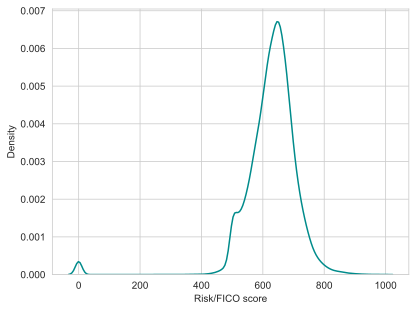

<IPython.core.display.Javascript object>

In [26]:
NaN_free_data = df_reject.dropna(subset=["Risk/FICO score"])

sns.set_style("whitegrid")
sns.kdeplot(NaN_free_data["Risk/FICO score"], bw_adjust=3, color="darkcyan")
plt.show()

Around 66.4% of rejected application Risk/FICO score entries are missing. In general, FICO score is an important parameter when considering credit application. The higher the score the less risky the credit. Many factors come into play when determining the FICO score, such as: Payment History (35%), Accounts Owed (30%), Length of Credit History (15%), and others. It could be that credit institution was unable to determine the FICO score and that lead to the rejection of the application. I will use the following strategy to deal with this:
1. Create a new feature to indicate weather FICO score is determinable when considering the application;
2. Fill the missing values with the average (not a big skew in the distribution) of FICO scores for rejected applications.

In [27]:
df_reject["Risk score uncertain"] = df_reject["Risk/FICO score"].isnull().astype(int)

<IPython.core.display.Javascript object>

In [28]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon            693.0   
1          1000  2007-05                Consolidating Debt            703.0   
2         11000  2007-05       Want to consolidate my debt            715.0   
3          6000  2007-05                           waksman            698.0   
4          1500  2007-05                            mdrigo            509.0   

  DTI (%) Zip code State Employment length (years)  Policy code  \
0     10%    481xx    NM                   4 years          0.0   
1     10%    010xx    MA                  < 1 year          0.0   
2     10%    212xx    MD                    1 year          0.0   
3  38.64%    017xx    MA                  < 1 year          0.0   
4   9.43%    209xx    MD                  < 1 year          0.0   

   Risk score uncertain  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

<IPython.core.display.Javascript object>

In [29]:
average_risk_reject = round(df_reject["Risk/FICO score"].mean())
average_risk_reject

628

<IPython.core.display.Javascript object>

In [30]:
df_reject["Risk/FICO score"].fillna(average_risk_reject, inplace=True)

<IPython.core.display.Javascript object>

In [31]:
df_reject["Risk/FICO score"] = df_reject["Risk/FICO score"].round()
df_reject["Risk/FICO score"] = df_reject["Risk/FICO score"].astype(int)

<IPython.core.display.Javascript object>

In [32]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon              693   
1          1000  2007-05                Consolidating Debt              703   
2         11000  2007-05       Want to consolidate my debt              715   
3          6000  2007-05                           waksman              698   
4          1500  2007-05                            mdrigo              509   

  DTI (%) Zip code State Employment length (years)  Policy code  \
0     10%    481xx    NM                   4 years          0.0   
1     10%    010xx    MA                  < 1 year          0.0   
2     10%    212xx    MD                    1 year          0.0   
3  38.64%    017xx    MA                  < 1 year          0.0   
4   9.43%    209xx    MD                  < 1 year          0.0   

   Risk score uncertain  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

<IPython.core.display.Javascript object>

In [33]:
NaN_data = df_reject["DTI (%)"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [34]:
df_reject["DTI (%)"] = df_reject["DTI (%)"].str.replace("%", "").astype(float)

<IPython.core.display.Javascript object>

In [35]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon              693   
1          1000  2007-05                Consolidating Debt              703   
2         11000  2007-05       Want to consolidate my debt              715   
3          6000  2007-05                           waksman              698   
4          1500  2007-05                            mdrigo              509   

   DTI (%) Zip code State Employment length (years)  Policy code  \
0    10.00    481xx    NM                   4 years          0.0   
1    10.00    010xx    MA                  < 1 year          0.0   
2    10.00    212xx    MD                    1 year          0.0   
3    38.64    017xx    MA                  < 1 year          0.0   
4     9.43    209xx    MD                  < 1 year          0.0   

   Risk score uncertain  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

<IPython.core.display.Javascript object>

Explanation of Zip code meaning:
- First Digit: Represents a group of U.S. states.;
- Second and Third Digits: Together, they represent a region in that group (or perhaps a large city in that region), which is the area distribution center for the USPS;
- Fourth and Fifth Digits: They typically represent a group of delivery addresses within that region.

So, state and first three digits together is more less redundant info. This feature will be removed. Overall, I don't expect state to be useful for predictions. However, it may be interesting to see in which states most accepted/rejected credit applications are.

In [36]:
df_reject.drop(columns=["Zip code"], inplace=True)

<IPython.core.display.Javascript object>

In [37]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon              693   
1          1000  2007-05                Consolidating Debt              703   
2         11000  2007-05       Want to consolidate my debt              715   
3          6000  2007-05                           waksman              698   
4          1500  2007-05                            mdrigo              509   

   DTI (%) State Employment length (years)  Policy code  Risk score uncertain  
0    10.00    NM                   4 years          0.0                     0  
1    10.00    MA                  < 1 year          0.0                     0  
2    10.00    MD                    1 year          0.0                     0  
3    38.64    MA                  < 1 year          0.0                     0  
4     9.43    MD                  < 1 year          0.0                     0

<IPython.core.display.Javascript object>

In [38]:
NaN_data = df_reject["State"].isna().sum()
NaN_data

22

<IPython.core.display.Javascript object>

In [39]:
unique = pd.unique(df_reject["State"])
unique

array(['NM', 'MA', 'MD', 'NY', 'IN', 'CO', 'KY', 'LA', 'PA', 'AL', 'TN',
       'TX', 'OH', 'VA', 'MO', 'MN', 'CT', 'CA', 'FL', 'GA', 'NE', 'KS',
       'AR', 'WI', 'AZ', 'WA', 'OR', 'NC', 'WV', 'UT', 'NJ', 'AK', 'SC',
       'VT', 'MS', 'DE', 'MI', 'IA', 'IL', 'OK', 'ME', 'HI', 'NH', 'DC',
       'RI', 'NV', 'ND', 'MT', 'WY', 'ID', 'SD', nan], dtype=object)

<IPython.core.display.Javascript object>

There are all 50 states plus District of Columbia (DC). The very small amount of missing data will be removed.

In [40]:
df_reject.dropna(subset=["State"], inplace=True)

<IPython.core.display.Javascript object>

In [41]:
NaN_data = df_reject["State"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [42]:
unique = pd.unique(df_reject["Employment length (years)"])
unique

array(['4 years', '< 1 year', '1 year', '3 years', '2 years', '10+ years',
       '9 years', '5 years', '7 years', '6 years', '8 years', nan],
      dtype=object)

<IPython.core.display.Javascript object>

In [43]:
NaN_data = df_reject["Employment length (years)"].isna().sum()
NaN_data

949702

<IPython.core.display.Javascript object>

In [44]:
94970200 / 27648741

3.434883346044581

<IPython.core.display.Javascript object>

Around 3.4% of rejected application employment length of the applicant score is missing. This parameter seems to be important and would be hardly imputed from the average or other features. As missing values constitute relatively small amount, those will be removed.

In [45]:
df_reject.dropna(subset=["Employment length (years)"], inplace=True)

<IPython.core.display.Javascript object>

In [46]:
NaN_data = df_reject["Employment length (years)"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

Years will be expressed as integers, <1 year changes to 0, and 10+ to 10. Such notation seems to reassemble ordinal encoding.

In [47]:
employment_length_map = {
    "< 1 year": 0,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

df_reject["Employment length (years)"] = df_reject["Employment length (years)"].map(
    employment_length_map
)

<IPython.core.display.Javascript object>

In [48]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon              693   
1          1000  2007-05                Consolidating Debt              703   
2         11000  2007-05       Want to consolidate my debt              715   
3          6000  2007-05                           waksman              698   
4          1500  2007-05                            mdrigo              509   

   DTI (%) State  Employment length (years)  Policy code  Risk score uncertain  
0    10.00    NM                          4          0.0                     0  
1    10.00    MA                          0          0.0                     0  
2    10.00    MD                          1          0.0                     0  
3    38.64    MA                          0          0.0                     0  
4     9.43    MD                          0          0.0                     0

<IPython.core.display.Javascript object>

In [49]:
unique = pd.unique(df_reject["Policy code"])
unique

array([ 0.,  2., nan])

<IPython.core.display.Javascript object>

In [50]:
values = df_reject["Policy code"].value_counts()
print(values)

0.0    26458395
2.0       81849
Name: Policy code, dtype: int64


<IPython.core.display.Javascript object>

In [51]:
unique = pd.unique(df_accept["policy_code"])
unique

array([ 1., nan])

<IPython.core.display.Javascript object>

Seems that vast majority of rejected applications have policy code 0, and accepted policy code 1. This may be just an indication whether to accept or reject the application after its evaluation, thus it would not be correct to use this feature for prediction as the feature itself is a predictor. Instead, I will create a separate feature to indicate that the application is from the rejected database.

In [52]:
df_reject.drop(columns=["Policy code"], inplace=True)

<IPython.core.display.Javascript object>

In [53]:
df_reject["Application status"] = 0

<IPython.core.display.Javascript object>

In [54]:
df_reject.head()

Amount (USD)     Date                             Title  Risk/FICO score  \
0          1000  2007-05  Wedding Covered but No Honeymoon              693   
1          1000  2007-05                Consolidating Debt              703   
2         11000  2007-05       Want to consolidate my debt              715   
3          6000  2007-05                           waksman              698   
4          1500  2007-05                            mdrigo              509   

   DTI (%) State  Employment length (years)  Risk score uncertain  \
0    10.00    NM                          4                     0   
1    10.00    MA                          0                     0   
2    10.00    MD                          1                     0   
3    38.64    MA                          0                     0   
4     9.43    MD                          0                     0   

   Application status  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

<IPython.core.display.Javascript object>

In [55]:
feature_order = [
    "Amount (USD)",
    "Title",
    "Risk/FICO score",
    "Risk score uncertain",
    "DTI (%)",
    "Employment length (years)",
    "Date",
    "State",
    "Application status",
]
df_reject = df_reject[feature_order]

<IPython.core.display.Javascript object>

In [56]:
df_reject.head()

Amount (USD)                             Title  Risk/FICO score  \
0          1000  Wedding Covered but No Honeymoon              693   
1          1000                Consolidating Debt              703   
2         11000       Want to consolidate my debt              715   
3          6000                           waksman              698   
4          1500                            mdrigo              509   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0    10.00                          4  2007-05    NM   
1                     0    10.00                          0  2007-05    MA   
2                     0    10.00                          1  2007-05    MD   
3                     0    38.64                          0  2007-05    MA   
4                     0     9.43                          0  2007-05    MD   

   Application status  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

<IPython.core.display.Javascript object>

## Cleaning of accepted application data

In [57]:
features_that_match = [
    "loan_amnt",
    "title",
    "dti",
    "emp_length",
    "addr_state",
    "issue_d",
    "fico_range_low",
    "fico_range_high",
]
df_accept_match = df_accept[features_that_match]

<IPython.core.display.Javascript object>

In [58]:
df_accept_match.head()

loan_amnt               title    dti emp_length addr_state   issue_d  \
0     3600.0  Debt consolidation   5.91  10+ years         PA  Dec-2015   
1    24700.0            Business  16.06  10+ years         SD  Dec-2015   
2    20000.0                 NaN  10.78  10+ years         IL  Dec-2015   
3    35000.0  Debt consolidation  17.06  10+ years         NJ  Dec-2015   
4    10400.0      Major purchase  25.37    3 years         PA  Dec-2015   

   fico_range_low  fico_range_high  
0           675.0            679.0  
1           715.0            719.0  
2           695.0            699.0  
3           785.0            789.0  
4           695.0            699.0

<IPython.core.display.Javascript object>

In [59]:
# Rename columns for convenience (inplace=True, so original df is modified, default is False)
df_accept_match.rename(
    columns={
        "loan_amnt": "Amount (USD)",
        "Application Date": "Date",
        "title": "Title",
        "dti": "DTI (%)",
        "emp_length": "Employment length (years)",
        "addr_state": "State",
        "issue_d": "Date",
    },
    inplace=True,
)

/var/folders/w3/7mgz888n5b98lkft49p_r81r0000gn/T/ipykernel_1904/3278056870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accept_match.rename(


<IPython.core.display.Javascript object>

In [60]:
df_accept_match.head()

Amount (USD)               Title  DTI (%) Employment length (years) State  \
0        3600.0  Debt consolidation     5.91                 10+ years    PA   
1       24700.0            Business    16.06                 10+ years    SD   
2       20000.0                 NaN    10.78                 10+ years    IL   
3       35000.0  Debt consolidation    17.06                 10+ years    NJ   
4       10400.0      Major purchase    25.37                   3 years    PA   

       Date  fico_range_low  fico_range_high  
0  Dec-2015           675.0            679.0  
1  Dec-2015           715.0            719.0  
2  Dec-2015           695.0            699.0  
3  Dec-2015           785.0            789.0  
4  Dec-2015           695.0            699.0

<IPython.core.display.Javascript object>

In [61]:
NaN_data = df_accept_match["Amount (USD)"].isna().sum()
NaN_data

33

<IPython.core.display.Javascript object>

In [62]:
df_accept_match = df_accept_match.replace([np.inf, -np.inf], np.nan)

<IPython.core.display.Javascript object>

In [63]:
NaN_data = df_accept_match["Amount (USD)"].isna().sum()
NaN_data

33

<IPython.core.display.Javascript object>

Seems that there was some infinite values present. This small amount will be removed.

In [64]:
df_accept_match.dropna(subset=["Amount (USD)"], inplace=True)

<IPython.core.display.Javascript object>

In [65]:
df_accept_match["Amount (USD)"] = df_accept_match["Amount (USD)"].round()
df_accept_match["Amount (USD)"] = df_accept_match["Amount (USD)"].astype(int)

<IPython.core.display.Javascript object>

In [66]:
df_accept_match.head()

Amount (USD)               Title  DTI (%) Employment length (years) State  \
0          3600  Debt consolidation     5.91                 10+ years    PA   
1         24700            Business    16.06                 10+ years    SD   
2         20000                 NaN    10.78                 10+ years    IL   
3         35000  Debt consolidation    17.06                 10+ years    NJ   
4         10400      Major purchase    25.37                   3 years    PA   

       Date  fico_range_low  fico_range_high  
0  Dec-2015           675.0            679.0  
1  Dec-2015           715.0            719.0  
2  Dec-2015           695.0            699.0  
3  Dec-2015           785.0            789.0  
4  Dec-2015           695.0            699.0

<IPython.core.display.Javascript object>

In [67]:
NaN_data = df_accept_match["DTI (%)"].isna().sum()
NaN_data

1711

<IPython.core.display.Javascript object>

Small amount of debt-to-income ratio is missing, thus can be removed.

In [68]:
df_accept_match.dropna(subset=["DTI (%)"], inplace=True)

<IPython.core.display.Javascript object>

In [69]:
NaN_data = df_accept_match["Employment length (years)"].isna().sum()
NaN_data

145309

<IPython.core.display.Javascript object>

In [70]:
14530900 / 2260701

6.427608073778885

<IPython.core.display.Javascript object>

Around 6.4% of accepted application employment length of the applicant score is missing. This small amount of applications will be removed.

In [71]:
df_accept_match.dropna(subset=["Employment length (years)"], inplace=True)

<IPython.core.display.Javascript object>

In [72]:
employment_length_map = {
    "< 1 year": 0,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

df_accept_match["Employment length (years)"] = df_accept_match[
    "Employment length (years)"
].map(employment_length_map)

<IPython.core.display.Javascript object>

In [73]:
df_accept_match.head()

Amount (USD)               Title  DTI (%)  Employment length (years) State  \
0          3600  Debt consolidation     5.91                         10    PA   
1         24700            Business    16.06                         10    SD   
2         20000                 NaN    10.78                         10    IL   
3         35000  Debt consolidation    17.06                         10    NJ   
4         10400      Major purchase    25.37                          3    PA   

       Date  fico_range_low  fico_range_high  
0  Dec-2015           675.0            679.0  
1  Dec-2015           715.0            719.0  
2  Dec-2015           695.0            699.0  
3  Dec-2015           785.0            789.0  
4  Dec-2015           695.0            699.0

<IPython.core.display.Javascript object>

In [74]:
unique = pd.unique(df_accept_match["Employment length (years)"])
unique

array([10,  3,  4,  6,  1,  7,  8,  5,  2,  9,  0])

<IPython.core.display.Javascript object>

In [75]:
NaN_data = df_accept_match["State"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [76]:
unique = pd.unique(df_accept_match["State"])
unique

array(['PA', 'SD', 'IL', 'NJ', 'GA', 'MN', 'SC', 'RI', 'TX', 'NC', 'CA',
       'VA', 'AZ', 'NY', 'IN', 'MD', 'KS', 'NM', 'AL', 'WA', 'MO', 'OH',
       'LA', 'FL', 'CO', 'MI', 'DC', 'MA', 'WI', 'VT', 'DE', 'TN', 'NH',
       'NE', 'CT', 'OR', 'AR', 'MT', 'NV', 'WV', 'HI', 'OK', 'KY', 'WY',
       'MS', 'UT', 'ND', 'ME', 'AK', 'ID', 'IA'], dtype=object)

<IPython.core.display.Javascript object>

In [77]:
NaN_data = df_accept_match["Date"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [78]:
df_accept_match["Date"] = pd.to_datetime(
    df_accept_match["Date"], format="%b-%Y"
).dt.strftime("%Y-%m")

<IPython.core.display.Javascript object>

In [79]:
df_accept_match.head()

Amount (USD)               Title  DTI (%)  Employment length (years) State  \
0          3600  Debt consolidation     5.91                         10    PA   
1         24700            Business    16.06                         10    SD   
2         20000                 NaN    10.78                         10    IL   
3         35000  Debt consolidation    17.06                         10    NJ   
4         10400      Major purchase    25.37                          3    PA   

      Date  fico_range_low  fico_range_high  
0  2015-12           675.0            679.0  
1  2015-12           715.0            719.0  
2  2015-12           695.0            699.0  
3  2015-12           785.0            789.0  
4  2015-12           695.0            699.0

<IPython.core.display.Javascript object>

In [80]:
NaN_data = df_accept_match["fico_range_low"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [81]:
NaN_data = df_accept_match["fico_range_high"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

All the risk assessments were done for accepted applications. However, two FICO values are provided. The average will be calculated to make it comparable to the rejected applications.

In [82]:
df_accept_match["Risk/FICO score"] = (
    df_accept_match["fico_range_low"] + df_accept_match["fico_range_high"]
) / 2
df_accept_match["Risk/FICO score"] = df_accept_match["Risk/FICO score"].round()
df_accept_match["Risk/FICO score"] = df_accept_match["Risk/FICO score"].astype(int)

<IPython.core.display.Javascript object>

In [83]:
df_accept_match.head()

Amount (USD)               Title  DTI (%)  Employment length (years) State  \
0          3600  Debt consolidation     5.91                         10    PA   
1         24700            Business    16.06                         10    SD   
2         20000                 NaN    10.78                         10    IL   
3         35000  Debt consolidation    17.06                         10    NJ   
4         10400      Major purchase    25.37                          3    PA   

      Date  fico_range_low  fico_range_high  Risk/FICO score  
0  2015-12           675.0            679.0              677  
1  2015-12           715.0            719.0              717  
2  2015-12           695.0            699.0              697  
3  2015-12           785.0            789.0              787  
4  2015-12           695.0            699.0              697

<IPython.core.display.Javascript object>

In [84]:
df_accept_match.drop(columns=["fico_range_low"], inplace=True)
df_accept_match.drop(columns=["fico_range_high"], inplace=True)

<IPython.core.display.Javascript object>

In [85]:
df_accept_match["Risk score uncertain"] = 0

<IPython.core.display.Javascript object>

In [86]:
df_accept_match["Application status"] = 1

<IPython.core.display.Javascript object>

In [87]:
df_accept_match.head()

Amount (USD)               Title  DTI (%)  Employment length (years) State  \
0          3600  Debt consolidation     5.91                         10    PA   
1         24700            Business    16.06                         10    SD   
2         20000                 NaN    10.78                         10    IL   
3         35000  Debt consolidation    17.06                         10    NJ   
4         10400      Major purchase    25.37                          3    PA   

      Date  Risk/FICO score  Risk score uncertain  Application status  
0  2015-12              677                     0                   1  
1  2015-12              717                     0                   1  
2  2015-12              697                     0                   1  
3  2015-12              787                     0                   1  
4  2015-12              697                     0                   1

<IPython.core.display.Javascript object>

In [88]:
feature_order = [
    "Amount (USD)",
    "Title",
    "Risk/FICO score",
    "Risk score uncertain",
    "DTI (%)",
    "Employment length (years)",
    "Date",
    "State",
    "Application status",
]
df_accept_match = df_accept_match[feature_order]

<IPython.core.display.Javascript object>

In [89]:
df_accept_match.head()

Amount (USD)               Title  Risk/FICO score  Risk score uncertain  \
0          3600  Debt consolidation              677                     0   
1         24700            Business              717                     0   
2         20000                 NaN              697                     0   
3         35000  Debt consolidation              787                     0   
4         10400      Major purchase              697                     0   

   DTI (%)  Employment length (years)     Date State  Application status  
0     5.91                         10  2015-12    PA                   1  
1    16.06                         10  2015-12    SD                   1  
2    10.78                         10  2015-12    IL                   1  
3    17.06                         10  2015-12    NJ                   1  
4    25.37                          3  2015-12    PA                   1

<IPython.core.display.Javascript object>

## Combined dataframe

In [90]:
df_full = pd.concat([df_accept_match, df_reject], ignore_index=True)

<IPython.core.display.Javascript object>

In [91]:
df_full = df_full.sample(frac=1, random_state=93).reset_index(
    drop=True
)  # 1 to sample all rows!!

<IPython.core.display.Javascript object>

In [92]:
df_full.head()

Amount (USD)                    Title  Risk/FICO score  \
0         20000       Debt consolidation              692   
1          5000       debt_consolidation              628   
2          5000  Credit card refinancing              628   
3         15000           small_business              628   
4         30000              Home buying              628   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0     8.68                          0  2017-12    NJ   
1                     1    52.78                          0  2016-01    NM   
2                     1    34.18                          0  2018-10    OH   
3                     1     3.33                          0  2015-10    NY   
4                     1    47.71                          0  2018-05    NJ   

   Application status  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

<IPython.core.display.Javascript object>

In [93]:
df_full.tail()

Amount (USD)                    Title  Risk/FICO score  \
28654706         15000       debt_consolidation              662   
28654707          1800       Debt consolidation              505   
28654708          3000       debt_consolidation              628   
28654709          2000       debt_consolidation              628   
28654710         10000  Credit card refinancing              628   

          Risk score uncertain  DTI (%)  Employment length (years)     Date  \
28654706                     0    16.10                          0  2014-10   
28654707                     0    14.66                          0  2016-10   
28654708                     1    12.30                          5  2017-01   
28654709                     1    39.50                          0  2017-01   
28654710                     1    19.11                          0  2018-06   

         State  Application status  
28654706    NY                   0  
28654707    CA                   0  
28654708    FL                   0  
28654709    NY                   0  
28654710    MN                   0

<IPython.core.display.Javascript object>

In [94]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28654711 entries, 0 to 28654710
Data columns (total 9 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Amount (USD)               int64  
 1   Title                      object 
 2   Risk/FICO score            int64  
 3   Risk score uncertain       int64  
 4   DTI (%)                    float64
 5   Employment length (years)  int64  
 6   Date                       object 
 7   State                      object 
 8   Application status         int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 1.9+ GB


<IPython.core.display.Javascript object>

In [95]:
df_full.shape

(28654711, 9)

<IPython.core.display.Javascript object>

In [96]:
df_full.describe()

Amount (USD)  Risk/FICO score  Risk score uncertain       DTI (%)  \
count  2.865471e+07     2.865471e+07          2.865471e+07  2.865471e+07   
mean   1.332255e+04     6.331378e+02          6.131085e-01  1.363353e+02   
std    1.468441e+04     5.444864e+01          4.870385e-01  1.034160e+04   
min    0.000000e+00     0.000000e+00          0.000000e+00 -1.000000e+00   
25%    5.000000e+03     6.280000e+02          0.000000e+00  8.660000e+00   
50%    1.000000e+04     6.280000e+02          1.000000e+00  1.975000e+01   
75%    2.000000e+04     6.280000e+02          1.000000e+00  3.518000e+01   
max    1.400000e+06     9.900000e+02          1.000000e+00  5.000003e+07   

       Employment length (years)  Application status  
count               2.865471e+07        2.865471e+07  
mean                1.100778e+00        7.376267e-02  
std                 2.543792e+00        2.613843e-01  
min                 0.000000e+00        0.000000e+00  
25%                 0.000000e+00        0.000000e+00  
50%                 0.000000e+00        0.000000e+00  
75%                 0.000000e+00        0.000000e+00  
max                 1.000000e+01        1.000000e+00

<IPython.core.display.Javascript object>

In [97]:
NaN_data = df_full["Title"].isna().sum()
NaN_data

21393

<IPython.core.display.Javascript object>

There are some missing titles for the applications, these can be easily replaced by 'Unknown'.

In [98]:
df_full["Title"].fillna("Unknown", inplace=True)

<IPython.core.display.Javascript object>

In [99]:
NaN_data = df_full["Title"].isna().sum()
NaN_data

0

<IPython.core.display.Javascript object>

In [100]:
counts = df_full["Amount (USD)"].value_counts()
strict_counts = counts.loc[0]
strict_counts

1270

<IPython.core.display.Javascript object>

Some applications are not valid, as the amount requested/given is 0. These will be removed.

In [101]:
zero_amount = df_full[df_full["Amount (USD)"] == 0].index
df_full.drop(zero_amount, inplace=True)

<IPython.core.display.Javascript object>

In [102]:
df_full.head()

Amount (USD)                    Title  Risk/FICO score  \
0         20000       Debt consolidation              692   
1          5000       debt_consolidation              628   
2          5000  Credit card refinancing              628   
3         15000           small_business              628   
4         30000              Home buying              628   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0     8.68                          0  2017-12    NJ   
1                     1    52.78                          0  2016-01    NM   
2                     1    34.18                          0  2018-10    OH   
3                     1     3.33                          0  2015-10    NY   
4                     1    47.71                          0  2018-05    NJ   

   Application status  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

<IPython.core.display.Javascript object>

## Text data

In [103]:
# Fully ChatGPT-4 suggested code
def clean_text(text):
    if not isinstance(text, str):  # Check if 'text' is a string object
        return ""  # use 'return text' to return it unchanged
    # Convert text to lowercase
    text = text.lower()
    text = re.sub(r"[_]", " ", text)  # Replace underscores with spaces
    text = re.sub(
        r"[^\w\s]", "", text
    )  # Remove all non-alphanumeric characters except spaces
    # Tokenize text (split it into words)
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(
        stopwords.words("english")
    )  # Calling "set" on stopwords make this operation faster
    tokens = [word for word in tokens if word not in stop_words]
    # Stemming (reduce words to their root form)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join the tokens back into a single string
    cleaned_text = " ".join(tokens)
    return cleaned_text


# saved df
file_path = "df_full_text.pkl"

if os.path.exists(file_path):
    # If df_full_text.pkl exists, load df_full_text from storage
    df_full_text = pd.read_pickle(file_path)
else:
    # Wrap celll with tqdm for a progress bar
    tqdm.pandas(desc="Cleaning titles")

    # Now use progress_apply instead of apply
    df_full["Clean title"] = df_full["Title"].progress_apply(clean_text)

    df_full_text = df_full
    df_full_text.to_pickle(file_path)

<IPython.core.display.Javascript object>

- Lowercasing: Converts all the text to lowercase to ensure consistency.
- Special Character Removal: Removes underscores and other non-alphanumeric characters, except spaces.
- Tokenization: Splits the text into individual words.
- Stopword Removal: Removes common stopwords (e.g., "and", "the", "is") that usually don't carry much meaning.
- Stemming: Reduces words to their root or base form (e.g., "running" to "run").

**tqdm** package helps to visualize progress when one is uncertain whether the program has crashed, stuck in a loop, or just takes a lot to complete the job.

**.pkl** file is where I save part of the work so I don't need to redo it when I rerun the notebook.

In [104]:
df_full = df_full_text

<IPython.core.display.Javascript object>

In [105]:
df_full.head()

Amount (USD)                    Title  Risk/FICO score  \
0         20000       Debt consolidation              692   
1          5000       debt_consolidation              628   
2          5000  Credit card refinancing              628   
3         15000           small_business              628   
4         30000              Home buying              628   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0     8.68                          0  2017-12    NJ   
1                     1    52.78                          0  2016-01    NM   
2                     1    34.18                          0  2018-10    OH   
3                     1     3.33                          0  2015-10    NY   
4                     1    47.71                          0  2018-05    NJ   

   Application status           Clean title  
0                   0         debt consolid  
1                   0         debt consolid  
2                   0  credit card refinanc  
3                   0            small busi  
4                   0              home buy

<IPython.core.display.Javascript object>

In [106]:
df_full.tail()

Amount (USD)                    Title  Risk/FICO score  \
28654706         15000       debt_consolidation              662   
28654707          1800       Debt consolidation              505   
28654708          3000       debt_consolidation              628   
28654709          2000       debt_consolidation              628   
28654710         10000  Credit card refinancing              628   

          Risk score uncertain  DTI (%)  Employment length (years)     Date  \
28654706                     0    16.10                          0  2014-10   
28654707                     0    14.66                          0  2016-10   
28654708                     1    12.30                          5  2017-01   
28654709                     1    39.50                          0  2017-01   
28654710                     1    19.11                          0  2018-06   

         State  Application status           Clean title  
28654706    NY                   0         debt consolid  
28654707    CA                   0         debt consolid  
28654708    FL                   0         debt consolid  
28654709    NY                   0         debt consolid  
28654710    MN                   0  credit card refinanc

<IPython.core.display.Javascript object>

In [107]:
popular_words = nltk.word_tokenize(" ".join(df_full["Clean title"].values))

word_count = Counter(popular_words)

# Print 20 most common words and their counts
for word, count in word_count.most_common(20):
    print(f"{word}: {count}")

consolid: 13052036
debt: 13045615
credit: 4016874
card: 4011525
refinanc: 2665312
home: 1749757
improv: 1262987
car: 1256349
purchas: 973131
major: 971316
busi: 861684
financ: 753851
medic: 734872
move: 692218
buy: 482774
loan: 412128
expens: 400381
reloc: 326257
vacat: 309087
small: 304728


<IPython.core.display.Javascript object>

The following code will vectorize cleaned titles and cluster them into 10 (unoptimised value, more like a proof of concept) distinct clusters.

In [108]:
# Vectorize
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df_full["Clean title"])

# Cluster w/ k-means
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_full["Cluster"] = kmeans.fit_predict(X)

<IPython.core.display.Javascript object>

In [109]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(10):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")
    print()

Cluster 0:
 reloc
 vacat
 hous
 loan
 green
 wed
 renew
 energi
 unknown
 pay

Cluster 1:
 consolid
 debt
 credit
 card
 refinanc
 loan
 zero
 dump
 driveway
 drown

Cluster 2:
 refinanc
 card
 credit
 debt
 loan
 consolid
 person
 pay
 wed
 busi

Cluster 3:
 improv
 home
 loan
 consolid
 debt
 credit
 pay
 card
 payoff
 need

Cluster 4:
 major
 purchas
 loan
 home
 consolid
 debt
 person
 pay
 credit
 card

Cluster 5:
 car
 financ
 loan
 purchas
 consolid
 refinanc
 credit
 debt
 expens
 card

Cluster 6:
 busi
 loan
 small
 expans
 start
 consolid
 startup
 expens
 debt
 improv

Cluster 7:
 medic
 expens
 loan
 consolid
 debt
 credit
 card
 pay
 payoff
 car

Cluster 8:
 buy
 home
 car
 loan
 debt
 help
 pay
 consolid
 small
 need

Cluster 9:
 credit
 card
 consolid
 loan
 debt
 financ
 car
 home
 small
 expens



<IPython.core.display.Javascript object>

In [110]:
df_full.head()

Amount (USD)                    Title  Risk/FICO score  \
0         20000       Debt consolidation              692   
1          5000       debt_consolidation              628   
2          5000  Credit card refinancing              628   
3         15000           small_business              628   
4         30000              Home buying              628   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0     8.68                          0  2017-12    NJ   
1                     1    52.78                          0  2016-01    NM   
2                     1    34.18                          0  2018-10    OH   
3                     1     3.33                          0  2015-10    NY   
4                     1    47.71                          0  2018-05    NJ   

   Application status           Clean title  Cluster  
0                   0         debt consolid        1  
1                   0         debt consolid        1  
2                   0  credit card refinanc        2  
3                   0            small busi        6  
4                   0              home buy        8

<IPython.core.display.Javascript object>

People seem to ask for the loans for the following reasons:
- C0: Relocation/vacation/honeymoon
- C1: Debt consolidation
- C2: Credit refinance/ other expense refinanse
- C3: Home improvement
- C4: Major purchase - house
- C5: Car purchase
- C:6 Business loan
- C:7 Medical expenses
- C:8 Home buy
- C:9 Credit card

The number of cathegories can be reduced here as follows:
- CAT1 (C0) Relocation/travel
- CAT2 (C1, C2, C9) Loan refinancing
- CAT3 (C3) Repairs
- CAT4 (C4, C8) Real estate
- CAT5 (C5) Car purchase
- CAT6 (C6) Business loan
- CAT7 (C7) Medical expenses

In [111]:
def map_cluster_to_category(cluster):
    category_mapping = {
        0: "Relocation/travel/other",
        1: "Refinancing",
        2: "Refinancing",
        3: "Repairs",
        4: "Real estate",
        5: "Car purchase",
        6: "Business loan",
        7: "Medical expenses",
        8: "Real estate",
        9: "Refinancing",
    }
    return category_mapping.get(cluster)


df_full["Loan type"] = df_full["Cluster"].apply(map_cluster_to_category)

<IPython.core.display.Javascript object>

In [112]:
df_full.head()

Amount (USD)                    Title  Risk/FICO score  \
0         20000       Debt consolidation              692   
1          5000       debt_consolidation              628   
2          5000  Credit card refinancing              628   
3         15000           small_business              628   
4         30000              Home buying              628   

   Risk score uncertain  DTI (%)  Employment length (years)     Date State  \
0                     0     8.68                          0  2017-12    NJ   
1                     1    52.78                          0  2016-01    NM   
2                     1    34.18                          0  2018-10    OH   
3                     1     3.33                          0  2015-10    NY   
4                     1    47.71                          0  2018-05    NJ   

   Application status           Clean title  Cluster      Loan type  
0                   0         debt consolid        1    Refinancing  
1                   0         debt consolid        1    Refinancing  
2                   0  credit card refinanc        2    Refinancing  
3                   0            small busi        6  Business loan  
4                   0              home buy        8    Real estate

<IPython.core.display.Javascript object>

In [113]:
df_full.drop(columns=["Title", "Clean title", "Cluster"], inplace=True)

<IPython.core.display.Javascript object>

In [114]:
feature_order = [
    "Amount (USD)",
    "Loan type",
    "Risk/FICO score",
    "Risk score uncertain",
    "DTI (%)",
    "Employment length (years)",
    "Date",
    "State",
    "Application status",
]
df_full = df_full[feature_order]

<IPython.core.display.Javascript object>

In [115]:
df_full.head()

Amount (USD)      Loan type  Risk/FICO score  Risk score uncertain  \
0         20000    Refinancing              692                     0   
1          5000    Refinancing              628                     1   
2          5000    Refinancing              628                     1   
3         15000  Business loan              628                     1   
4         30000    Real estate              628                     1   

   DTI (%)  Employment length (years)     Date State  Application status  
0     8.68                          0  2017-12    NJ                   0  
1    52.78                          0  2016-01    NM                   0  
2    34.18                          0  2018-10    OH                   0  
3     3.33                          0  2015-10    NY                   0  
4    47.71                          0  2018-05    NJ                   0

<IPython.core.display.Javascript object>

In [116]:
df_full.tail()

Amount (USD)    Loan type  Risk/FICO score  Risk score uncertain  \
28654706         15000  Refinancing              662                     0   
28654707          1800  Refinancing              505                     0   
28654708          3000  Refinancing              628                     1   
28654709          2000  Refinancing              628                     1   
28654710         10000  Refinancing              628                     1   

          DTI (%)  Employment length (years)     Date State  \
28654706    16.10                          0  2014-10    NY   
28654707    14.66                          0  2016-10    CA   
28654708    12.30                          5  2017-01    FL   
28654709    39.50                          0  2017-01    NY   
28654710    19.11                          0  2018-06    MN   

          Application status  
28654706                   0  
28654707                   0  
28654708                   0  
28654709                   0  
28654710                   0

<IPython.core.display.Javascript object>

In [117]:
df_full.describe()

Amount (USD)  Risk/FICO score  Risk score uncertain       DTI (%)  \
count  2.865344e+07     2.865344e+07          2.865344e+07  2.865344e+07   
mean   1.332314e+04     6.331380e+02          6.130915e-01  1.363414e+02   
std    1.468447e+04     5.444984e+01          4.870424e-01  1.034183e+04   
min    2.500000e+01     0.000000e+00          0.000000e+00 -1.000000e+00   
25%    5.000000e+03     6.280000e+02          0.000000e+00  8.670000e+00   
50%    1.000000e+04     6.280000e+02          1.000000e+00  1.975000e+01   
75%    2.000000e+04     6.280000e+02          1.000000e+00  3.518000e+01   
max    1.400000e+06     9.900000e+02          1.000000e+00  5.000003e+07   

       Employment length (years)  Application status  
count               2.865344e+07        2.865344e+07  
mean                1.100826e+00        7.376594e-02  
std                 2.543838e+00        2.613896e-01  
min                 0.000000e+00        0.000000e+00  
25%                 0.000000e+00        0.000000e+00  
50%                 0.000000e+00        0.000000e+00  
75%                 0.000000e+00        0.000000e+00  
max                 1.000000e+01        1.000000e+00

<IPython.core.display.Javascript object>

In [118]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28653441 entries, 0 to 28654710
Data columns (total 9 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Amount (USD)               int64  
 1   Loan type                  object 
 2   Risk/FICO score            int64  
 3   Risk score uncertain       int64  
 4   DTI (%)                    float64
 5   Employment length (years)  int64  
 6   Date                       object 
 7   State                      object 
 8   Application status         int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 2.1+ GB


<IPython.core.display.Javascript object>

In [119]:
df_full.shape

(28653441, 9)

<IPython.core.display.Javascript object>

# EDA

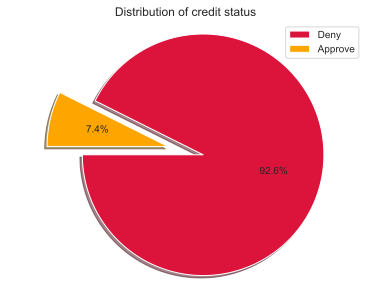

<IPython.core.display.Javascript object>

In [120]:
labels = "Deny", "Approve"
sizes = df_full["Application status"].value_counts()
colors = ["crimson", "orange"]
# Highlith small fraction
explode = (0.3, 0)

# Plot
plt.pie(
    sizes,
    explode=explode,
    colors=colors,
    autopct="%1.1f%%",
    shadow=True,
    startangle=180,
)
plt.legend(labels, loc="best")
# Draw as circle
plt.axis("equal")
plt.title("Distribution of credit status")
plt.show()

Important notice: we are dealing with imbalanced dataset.

In [121]:
df_full = df_full.rename(columns={"DTI (%)": "DTI (pct.)"})

<IPython.core.display.Javascript object>

In [123]:
# separate analysis showed significant presence of outliers in this feature that creates problem
# for correlation analysis. Here is the code to deal with the outliers by detecting and replacing them with average

# interquartile range (IQR) to detect outliers
Q1 = df_full["DTI (pct.)"].quantile(0.25)
Q3 = df_full["DTI (pct.)"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

average_dti = df_full["DTI (pct.)"].mean()

# replace outliers
df_full["DTI (pct.)"] = df_full["DTI (pct.)"].apply(
    lambda x: average_dti if (x < lower) or (x > upper) or (x < 0) else x
)

<IPython.core.display.Javascript object>

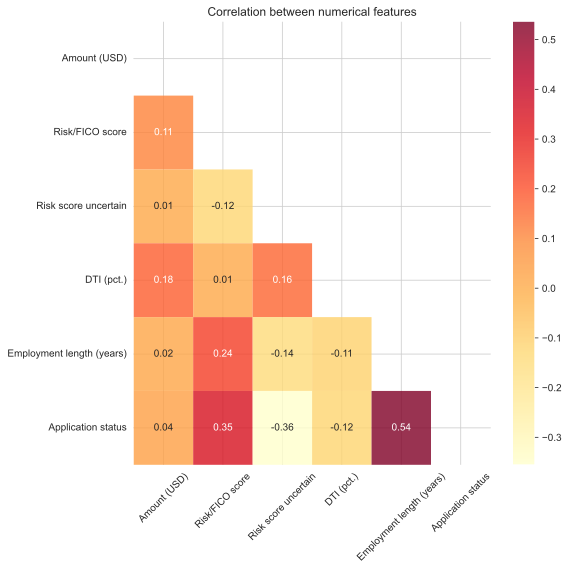

<IPython.core.display.Javascript object>

In [124]:
sns.set_style("whitegrid")

# Calculate Pearson correlation for numeric features ONLY
correlation_matrix = df_full.corr(numeric_only=True)

# Mask
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="YlOrRd", mask=mask, alpha=0.8
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation between numerical features")
plt.show()

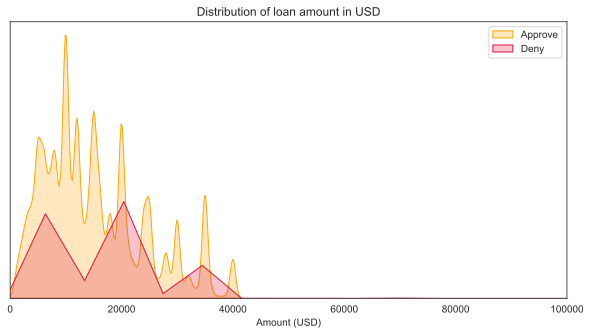

<IPython.core.display.Javascript object>

In [125]:
sns.set_style("white")

plt.figure(figsize=(10, 5))
sns.kdeplot(
    df_full[df_full["Application status"] == 1]["Amount (USD)"],
    color="orange",
    thresh=0.05,
    fill=True,
    label="Approve",
)
sns.kdeplot(
    df_full[df_full["Application status"] == 0]["Amount (USD)"],
    color="crimson",
    bw_adjust=0.5,
    thresh=0.05,
    fill=True,
    label="Deny",
)

# plt.xscale("log")

plt.title("Distribution of loan amount in USD")
plt.xlabel("Amount (USD)")
plt.ylabel("")

# Hide y-axis (no useful info as density)
plt.yticks([])

plt.xlim([0, 100000])
# plt.ylim([ymin, ymax])

plt.legend()
plt.show()

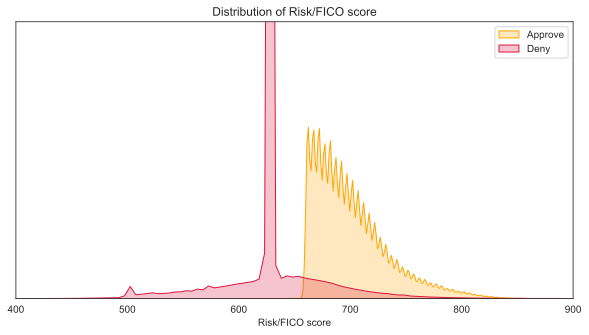

<IPython.core.display.Javascript object>

In [126]:
# Code reuse from 'Stroke' project

sns.set_style("white")

plt.figure(figsize=(10, 5))
sns.kdeplot(
    df_full[df_full["Application status"] == 1]["Risk/FICO score"],
    color="orange",
    thresh=0.05,
    fill=True,
    label="Approve",
)
sns.kdeplot(
    df_full[df_full["Application status"] == 0]["Risk/FICO score"],
    color="crimson",
    thresh=0.05,
    fill=True,
    label="Deny",
)

# plt.xscale("log")
# plt.xscale("log")

plt.title("Distribution of Risk/FICO score")
plt.xlabel("Risk/FICO score")
plt.ylabel("")

# Hide y-axis (no useful info as density)
plt.yticks([])

plt.ylim([0, 0.03])
plt.xlim([400, 900])

plt.legend()
plt.show()

There is relatively small amount of denied applications (not shown here), spike at FICO score 628 is due to the dataset fill with average denied FICO score.
It is clear that denied applications had lower FICO score. The steep distribution implies there is a boundary from which landing institution typically issues loans.

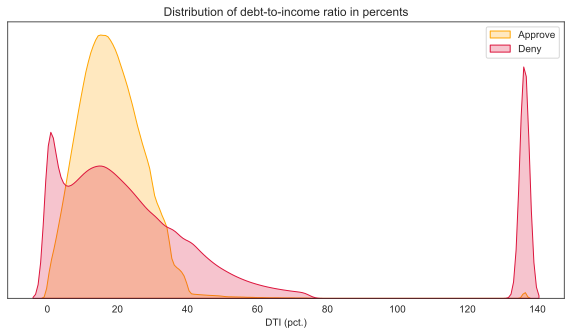

<IPython.core.display.Javascript object>

In [127]:
sns.set_style("white")

plt.figure(figsize=(10, 5))
sns.kdeplot(
    df_full[df_full["Application status"] == 1]["DTI (pct.)"],
    color="orange",
    thresh=0.05,
    fill=True,
    label="Approve",
)
sns.kdeplot(
    df_full[df_full["Application status"] == 0]["DTI (pct.)"],
    color="crimson",
    fill=True,
    label="Deny",
)

# plt.xscale("log")
# plt.xscale("log")

plt.title("Distribution of debt-to-income ratio in percents")
plt.xlabel("DTI (pct.)")
plt.ylabel("")

# Hide y-axis (no useful info as density)
plt.yticks([])

# plt.ylim([0, 0.03])
# plt.xlim([0, 100])

plt.legend()
plt.show()

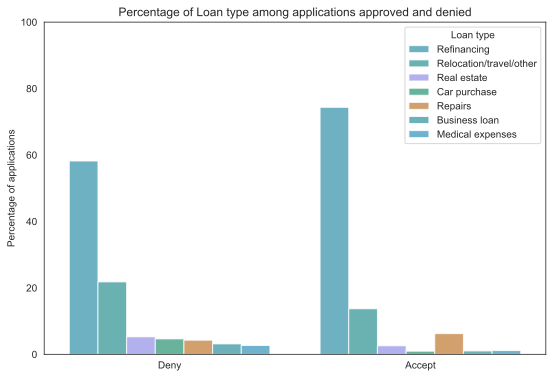

<IPython.core.display.Javascript object>

In [128]:
# Random color
color_options = 30
all_colors = sns.color_palette("husl", color_options)

feature = "Loan type"

# Efficient calculation of percentage
df_percentage = (
    df_full.groupby("Application status")[feature]
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(name="Percentage")
)

# New label for the 'Stroke" column
df_percentage["Application status"] = df_percentage["Application status"].map(
    {0: "Deny", 1: "Accept"}
)

# Randomly select colors based on unique feature values
num_unique_values = df_full[feature].nunique()
selected_colors = random.sample(all_colors, num_unique_values)

# Plotting
plt.figure(figsize=(9, 6))
sns.barplot(
    x="Application status",
    y="Percentage",
    hue=feature,
    data=df_percentage,
    palette=selected_colors,
    alpha=0.8,
)
# Show all percent
plt.ylim(0, 100)

# Set and plot
plt.title(f"Percentage of {feature} among applications approved and denied")
plt.ylabel("Percentage of applications")
plt.xlabel("")
plt.legend(title=feature, loc="upper right")
plt.show()

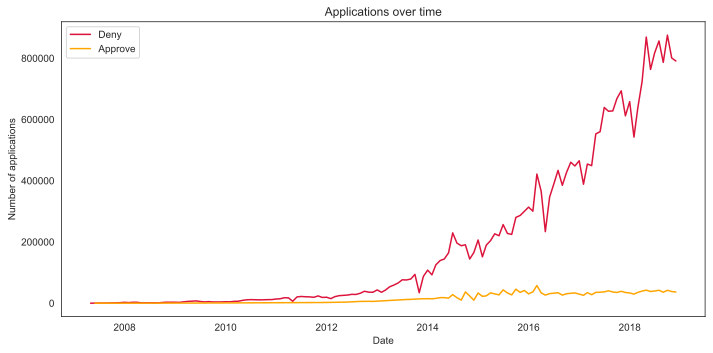

<IPython.core.display.Javascript object>

In [129]:
df_full["Date"] = pd.to_datetime(df_full["Date"], format="%Y-%m")

monthly_counts = (
    df_full.groupby(["Date", "Application status"]).size().reset_index(name="Counts")
)

pivot_counts = monthly_counts.pivot(
    index="Date", columns="Application status", values="Counts"
).reset_index()
pivot_counts.columns = ["Date", "Deny", "Approve"]

sns.set_style("white")
plt.figure(figsize=(10, 5))

sns.lineplot(data=pivot_counts, x="Date", y="Deny", color="crimson", label="Deny")
sns.lineplot(data=pivot_counts, x="Date", y="Approve", color="orange", label="Approve")

plt.title("Applications over time")
plt.xlabel("Date")
plt.ylabel("Number of applications")
plt.legend()

plt.tight_layout()
plt.show()

In [130]:
df_full.head()

Amount (USD)      Loan type  Risk/FICO score  Risk score uncertain  \
0         20000    Refinancing              692                     0   
1          5000    Refinancing              628                     1   
2          5000    Refinancing              628                     1   
3         15000  Business loan              628                     1   
4         30000    Real estate              628                     1   

   DTI (pct.)  Employment length (years)       Date State  Application status  
0        8.68                          0 2017-12-01    NJ                   0  
1       52.78                          0 2016-01-01    NM                   0  
2       34.18                          0 2018-10-01    OH                   0  
3        3.33                          0 2015-10-01    NY                   0  
4       47.71                          0 2018-05-01    NJ                   0

<IPython.core.display.Javascript object>

In [131]:
df_full.drop(columns=["Date", "State"], inplace=True)

<IPython.core.display.Javascript object>

In [132]:
df_full.tail()

Amount (USD)    Loan type  Risk/FICO score  Risk score uncertain  \
28654706         15000  Refinancing              662                     0   
28654707          1800  Refinancing              505                     0   
28654708          3000  Refinancing              628                     1   
28654709          2000  Refinancing              628                     1   
28654710         10000  Refinancing              628                     1   

          DTI (pct.)  Employment length (years)  Application status  
28654706       16.10                          0                   0  
28654707       14.66                          0                   0  
28654708       12.30                          5                   0  
28654709       39.50                          0                   0  
28654710       19.11                          0                   0

<IPython.core.display.Javascript object>

# Results and highlights

In [133]:
# Save the df to a CSV file, don't save indexing
df_full.to_csv("df_status.csv", index=False)

<IPython.core.display.Javascript object>

In [134]:
df_full.shape

(28653441, 7)

<IPython.core.display.Javascript object>

Two distinct datasets about accepted and rejected loan applications were joined keeping only the features they both had in common. This will be used for the ML model to predict whether a given application (assuming 7 features are known) should be accepted or rejected. The highlight of this part was the use of k-means algorithm to classify vectorized titles.